# Robinson Crusoe

With ``respy`` you are able to prototype a model similar to Keane and Wolpin (1997) in minutes. As economists love Robinsonades[<sup>1</sup>](#fn1), we will showcase the implementation of a the Robinson Crusoe economy as a discrete choice dynamic programming model. Throughout the notebook you find indented text which tell parts of Robinson's story and motivates the model. We will first set the scene with a broad introduction and then turn to the precise model specification. We continue by simulating the model and analyze its comparative statics. We then extend the model and showcase the estimation of the model parameters.  

Just to be clear, don't misinterpret the fact that we explain ``respy`` using such a simplistic model. ``respy`` is not a toy and can just as well solve state-of-the-art structural models. It's just easier to explain respy in a situation where we don't have to explain a complicated model at the same time. 

In [1]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import yaml
import seaborn as sns
import numpy as np

from pathlib import Path
from time import time

plt.style.use("../_static/respy.mplstyle")

## Introduction  

> After setting sail against his parents' wishes, being captured by pirates, escaping from them, building a plantation, and setting sail again to capture slaves in Africa, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats, and only some supplies. He goes fishing to make ends meet and if he is too tired he will relax in his hammock. But, he cannot relax to often as storing food is not easy on a tropical island.

In the discrete choice dynamic programming model, Robinson chooses every period to either go fishing, $a = 0$, or spend the day in the hammock, $a = 1$, to maximize his expected sum of discounted lifetime utility. The utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$. For working alternatives like fishing utility consists of two components, a wage and a non-pecuniary component.

$$
    U(s_t, a_t) = W(s_t, a_t) + N(s_t, a_t)
$$

For non-working alternatives like the hammock, $W(s_t, a_t) = 0$. The wage is defined as

$$\begin{align}
        W(s_t, a_t)  &= r_a \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
    \ln(W(s_t, a_t)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}
\end{align}$$


where $r_a$ is normally a market rental price for the skill units generated in the exponential expression. Another interpretation is that $ln(r_a)$ is simply the constant in the skill units. The skill units are generated by two components. $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and parameters related to the wage signaled by superscript $w$. The last term, $\epsilon_{at}$ is a random shock.

The non-pecuniary rewards for working alternatives are simply a vector dot product of covariates $x_t^w$ and parameters $\beta^w$. The superscript $w$ signals that the components belong to working alternatives.

$$
    N^w(s_t, a_t) = x_t^w\beta^w
$$

The non-pecuniary reward for non-working alternatives is very similar except that the shocks enter the equation additively. Superscript $n$ stands for non-pecuniary.

$$
    N^n(s_t, a_t) = x_t^n\beta^n + \epsilon_{at}
$$

Along with the lower triangular elements of the shock variance-covariance matrix of $\epsilon_t$, the utility parameters $\beta_a^w$, $\beta_a^n$ and $r_a$ form the main parameters of the model.

## Specification

How can we express the equations and parameters with ``respy``? The following cell contains the code to write a ``.csv`` file which is the cornerstone of a model as it contains all parameters and some other specifications. It is quickly written and easily loaded with ``pandas``.

In [2]:
%%writefile robinson_crusoe_basic.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1

Overwriting robinson_crusoe_basic.csv


In [3]:
params = pd.read_csv("robinson_crusoe_basic.csv", index_col=["category", "name"])
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

The parameters :class:`pd.DataFrame` contains a two-level :class:`pd.MultiIndex` to group parameters in categories. ``name`` should be uniquely assigned in each category or otherwise only the sum of identically named parameters is identified. ``value`` contains the value of the parameter. Note that we named Robinson's alternatives ``"fishing"`` and ``"hammock"`` and we have to use the names consistently. As long as you stick to lowercase letters separated by underscores, you can choose any name you want.

The parameter specification contains following entries:

- The first entry contains the discount factor of individuals.
- The second category ``"wage_fishing"`` contains the parameters of the log wage equation for fishing. The group contains only one name called ``"exp_fishing"`` where ``"exp_*"`` is an identifier in the model for experience accumulated in a certain alternative. ``respy`` requires that you respect those identifiers of which there are not many and reference your alternatives consistently with the same name. If you stick to lowercase letters possibly separated by underscores, you are fine.
- The third and fourth categories concern the non-pecuniary reward of fishing and relaxing in the hammock.
- ``"shocks_sdcorr"`` groups the lower triangular of the variance-covariance matrix of shocks.
- ``"lagged_choice_1_hammock"`` governs the distribution of previous choices at the begin of the model horizon.

``params`` is complemented with ``options`` which contains additional information. Here is short description:

- ``"n_periods"`` defines the number of periods for which decision rules are computed.
- ``"_seed"``: Seeds are used in every model component to ensure reproducibility.
- ``"estimation_draws"`` defines the number of draws used to simulate the choice probabilities with Monte Carlo integration.
- ``"estimation_tau"`` controls the smoothing to avoid zero-valued probabilities.
- ``"interpolation_points"`` controls how many states are used to approximate the value functions of others states in each period. ``-1`` turns the approximation off. The approximation is detailed in Keane and Wolpin (1994).
- ``"simulation_agents"`` defines how many agents are simulated.
- ``"solution_draws"`` defines the number of draws used to simulate the value functions.
- ``"covariates"`` is another dictionary where the key determines the covariate's name and the value is its definition. Here, we have to define what ``"constant"`` means. The covariate is created with :func:`pd.eval`.

In [4]:
%%writefile robinson_crusoe_basic.yaml

n_periods: 10
estimation_draws: 200
estimation_seed: 500
estimation_tau: 0.001
interpolation_points: -1
simulation_agents: 1_000
simulation_seed: 132
solution_draws: 500
solution_seed: 456
covariates:
    constant: "1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"

Overwriting robinson_crusoe_basic.yaml


In [5]:
options = yaml.safe_load(Path("robinson_crusoe_basic.yaml").read_text())
options

{'n_periods': 10,
 'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

## Simulation

We are now ready to simulate the model.

In [6]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [7]:
df.head(15)

,Identifier,Period,Choice,Wage,Experience_Fishing,Lagged_Choice_1,Type,Nonpecuniary_Reward_Fishing,Nonpecuniary_Reward_Hammock,Wage_Fishing,Flow_Utility_Fishing,Flow_Utility_Hammock,Value_Function_Fishing,Value_Function_Hammock,Shock_Reward_Fishing,Shock_Reward_Hammock,Discount_Rate
0,0,0,fishing,2.048628,0,hammock,0,-1.0,1.5,1.000000,1.048628,2.366250,19.630892,19.336065,2.048628,0.866250,0.95
1,0,1,fishing,2.814534,1,fishing,0,-1.0,2.5,1.105171,1.814534,2.317108,19.667179,18.563510,2.546696,-0.182892,0.95
2,0,2,fishing,3.943674,2,fishing,0,-1.0,2.5,1.221403,2.943674,2.974046,19.839016,18.322118,3.228807,0.474046,0.95
3,0,3,hammock,NaN,3,fishing,0,-1.0,2.5,1.349859,1.096816,2.676218,16.868733,16.916543,1.553359,0.176218,0.95
4,0,4,hammock,NaN,3,hammock,0,-1.0,1.5,1.349859,-0.875144,0.493640,12.590524,12.611304,0.092495,-1.006360,0.95
5,0,5,hammock,NaN,3,hammock,0,-1.0,1.5,1.349859,-0.366008,1.080653,10.680733,10.904368,0.469673,-0.419347,0.95
6,0,6,fishing,2.475731,3,hammock,0,-1.0,1.5,1.349859,1.475731,0.501567,9.867073,7.852518,1.834067,-0.998433,0.95
7,0,7,hammock,NaN,4,fishing,0,-1.0,2.5,1.491825,-0.099928,2.178192,6.065739,7.419904,0.603336,-0.321808,0.95
8,0,8,hammock,NaN,4,hammock,0,-1.0,1.5,1.491825,0.164102,1.257459,3.413636,3.665488,0.780321,-0.242541,0.95
9,0,9,fishing,10.234951,4,hammock,0,-1.0,1.5,1.491825,9.234951,1.501487,9.234951,1.501487,6.860693,0.001487,0.95


We can inspect Robinson's decisions period by period.

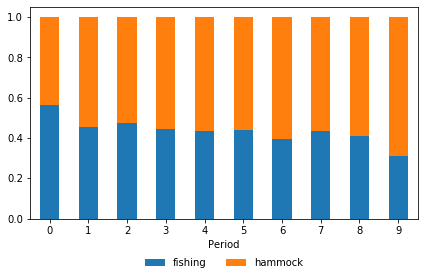

In [8]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()

We can also analyze the persistence in decisions.

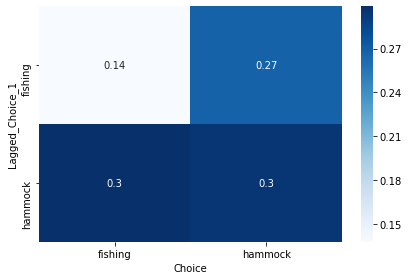

In [9]:
data = pd.crosstab(df.Lagged_Choice_1, df.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

## Analysis

We now study how Robinson's behavior changes as we increase the returns to experience. We do so by plotting the average level of final experience in the sample under the different parameterizations.

This analysis of the comparative statics of the model is straightforward to implement. In models of educational choice, this type of analysis is often applied to evaluate the effect of alternative tuition policies on average educational attainment. See Keane & Wolpin (1997, 2001) for example. The basic structure of the analysis remains the same.

In [10]:
# Specification of grid for evaluation
num_points = 15    
grid_start = 0.0
grid_stop = 0.3

grid_points = np.linspace(grid_start, grid_stop, num_points)

rslts = list()
for value in grid_points:
    
    params.loc["wage_fishing", "exp_fishing"] = value

    df = simulate(params)

    stat = df.groupby("Identifier")["Experience_Fishing"].max().mean()
    rslts.append(stat)

We collected all results in `rslts` and are ready to create a basic visualization.

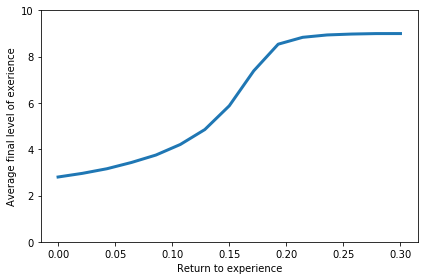

In [11]:
fig, ax = plt.subplots()

ax.plot(grid_points, rslts)

ax.set_ylim([0, 10])
ax.set_xlabel("Return to experience")
ax.set_ylabel("Average final level of exerience")

plt.show()
plt.close()

In the absence of any returns to experience, Robinson still spends more than two periods fishing. This share then increases with the return. Starting at around 0.2, Robinson spends all his time fishing.

## Extension

Let us make the model more interesting!

> At some point Crusoe notices that a group of cannibals occasionally visits the island and celebrate one of their dark rituals. But then, a prisoner can escape and becomes Crusoe's new friend Friday whom he teaches English. In return Friday can share his knowledge once to help Robinson improve his fishing skills, but that is only possible after Robinson tried at least once to go fishing.

A common extension to structural models is to increase the choice set. Here, we want to add another choice called `"friday"` which affects the utility of fishing. The choice should be available once, starting with the third period, and only after Robinson has been fishing before.

Note that, we load the example models with the function, `rp.get_example_model`. The command for the former model is `params, options, df = rp.get_example_model("robinson_crusoe_basic")`. You can use `with_data=False` to suppress the automatic simulation of a sample with this parameterization.

In [12]:
params, options = rp.get_example_model("robinson_crusoe_extended", with_data=False)

At first, take a look at the parameterization. There is a new positive parameter called `"contemplation_with_friday"` which enters the wage equation of fishing. The choice `"friday"` itself has a negative constant utility term which models the effort costs of learning and the food penalty. The variance-covariance matrix is also adjusted.

In [13]:
params

value
category                name                            
delta                   delta                       0.95
wage_fishing            exp_fishing                 0.10
                        contemplation_with_friday   0.40
nonpec_fishing          constant                   -1.00
nonpec_friday           constant                   -1.00
                        not_fishing_last_period    -1.00
nonpec_hammock          constant                    2.50
                        not_fishing_last_period    -1.00
shocks_sdcorr           sd_fishing                  1.00
                        sd_friday                   1.00
                        sd_hammock                  1.00
                        corr_friday_fishing         0.00
                        corr_hammock_fishing        0.00
                        corr_hammock_friday         0.00
lagged_choice_1_hammock constant                    1.00

Turning to the `options`, we can see that the new covariate `"contemplation_with_friday"` is only affecting utility if Robinson is experienced in fishing and only for one interaction with friday. This naturally limits the interaction with Friday. The key `"inadmissible_states"` can be used to restrict the choice Friday to the third and following periods. The first key matches a choice. The value of the key can be a list of strings. If the string evaluates to `True`, a utility penalty ensures that individuals will never choose the corresponding states. There exist some states in the state space which will never be reached because choices are mutually exclusive or are affected by other restrictions. Filters under `"core_state_space_filters"` can be used to purge those states from the state space, reducing runtime and memory consumption.

In [14]:
options

{'n_periods': 10,
 'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'contemplation_with_friday': 'exp_friday == 1 and exp_fishing >= 1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"},
 'inadmissible_states': {'friday': ['period < 2', 'exp_fishing == 0']},
 'core_state_space_filters': ["period > 0 and exp_fishing + exp_friday == period and lagged_choice_1 == 'hammock'",
  'period <= 2 and exp_friday != 0',
  'period >= 3 and period - exp_friday < 2',
  'exp_friday > 0 and exp_fishing == 0',
  "exp_friday > 0 and exp_fishing == 1 and lagged_choice_1 == 'fishing'",
  "period - exp_friday == 2 and lagged_choice_1 != 'friday' and period > 2",
  "exp_{i} == 0 and lagged_choice_1 == '{i}'"]}

Now, let us simulate a sample of the new model.

In [15]:
simulate = rp.get_simulate_func(params, options)

In [16]:
df = simulate(params)

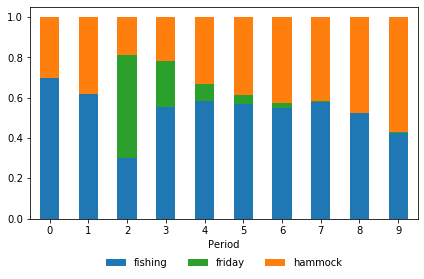

In [17]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax, color=["C0", "C2", "C1"],
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=3)

plt.show()
plt.close()

## Estimation

To estimate model parameters via maximum likelihood, ``respy`` relies on [``estimagic``](https://github.com/OpenSourceEconomics/estimagic), an open-source tool to estimate structural models and more. That way, ``respy`` only has to implement the likelihood function of your model, the optimization and standard error calculation is done by ``estimagic``. 

Unlike other optimization libraries, ``estimagic`` does not optimize over a simple vector of parameters, but instead stores parameters in a ``pd.DataFrame``, which makes it easier to parse them into the quantities we need, store lower and upper bounds together with parameters and express constraints on the parameters. 

For ``estimagic``, we need to pass constraints on the parameters in a list containing dictionaries. Each dictionary is a constraint. A constraint includes two components: First, we need to tell ``estimagic`` which parameters we want to constrain. This is achieved by specifying an index location which will be passed to `df.loc`. Then, define the type of the constraint. Here, we only impose the constraint that the shock parameters have to be valid variances and correlations.

Optionally, we can add a column ``"group"`` which is identical to the category column. The ``estimagic`` dashboard will then contain one parameter convergence plot per group instead of plotting all parameters in the same figure. Since ``respy`` has quite many parameters, this will make the plots much more readable.

In [18]:
from estimagic.optimization.optimize import maximize

In [19]:
params["group"] = params.index.get_level_values('category')

crit_func = rp.get_crit_func(params, options, df)
crit_func(params)

constr = rp.get_parameter_constraints("robinson")

In [20]:
results, params = maximize(
    crit_func, params, 
    "scipy_L-BFGS-B", 
    algo_options={"maxfun": 1}, 
    constraints=constr,
    dashboard=False
)

If we hadn't limited the optimization to just one function evaluation, ``params`` would contain the estimated parameters and results would contain additional information on the optimization. If we had set ``dashboard=True``, the call to maximize would have opened a browser window with the beautiful ``estimagic`` dashboard. Try it out if you run this notebook locally.

## Footnotes

<span id="fn1"><sup>1</sup>
    One of the earliest references of Robinsonades in economics can be found in Marx (1867). In the 37th footnote, he mentions that even Ricardo used the theme before him.
</span>

## References

> Keane, M. P. and Wolpin, K. I. (1997). [The Career Decisions of Young Men](https://doi.org/10.1086/262080). *Journal of Political Economy*, 105(3): 473-522.

> Marx, K. (1867). Das Kapital, Bd. 1. *MEW*, Bd, 23, 405